## Recommendation model 1: Item Search for Nearest Neighbors (ISNN)
### Model hyperparameter tuning and evaluation

### Springboard Capstone 2 project: building a recommendation engine
### John Burt

The goal of my project is to develop a working board game recommender using a dataset of explicit game ratings from the boardgamegeek.com forum site. My idea was to ask a user to name some games that they like, and my recommender algorithm will use those games to predict other games the user might like. The first problem I encountered was that any user asking for a recommendation will be unknown to the system - i.e., they are "new users" and that presents a classic cold start issue: how do you give a recommendation if you don't know much about the user? Well, we do have the user's "liked games" to work with, but any model will need to somehow match  that pattern of preferences to the preference patterns in the existing data.

### Model description
The first model I conceived estimates recommendations by creating a game (item) coordinate space. Each game is defined by a set of features/coordinates based on the dimensionally reduced ALS filled item x user ratings matrix (i.e, the utility matrix). Games rated similarly are closer in the game coordinate space, and so if a user likes one game, I can search for nearest neighbor games to use as recommendations.

### Evalution function
As with all models tested, I'm using a custom evaluation function to tune and assess the model:

- Dataset is the unfilled user x game ratings matrix, train/test split by user.
- For each test user:
    - From N*2 top rated games, randomly select N as "liked games" to use as model input (X values).
    - Remaining N top rated games assigned as holdouts to test for recommendations (y values).
    - User score = # holdout games recommended / N
    - The overall score is the mean user score for all test users.

### Purpose of this notebook:

Implement the the ISNN model, tune hyperparameters and evaluate model performance.



## Load data


In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the unfilled item-user utility matrix
df = pd.read_hdf(srcdir+'bgg_game_mx_unfilled_v2.h5', 'mx')

print('original: #games X #users:', df.shape)


original: #games X #users: (12120, 65168)


## Reduce the data for faster results

In [2]:
numusers = 30000
numgames = 6000
gameidx = np.array(range(numgames))
np.random.shuffle(gameidx)
useridx = np.array(range(numusers))
np.random.shuffle(useridx)
df = df.iloc[gameidx, useridx]
print('reduced: #games X #users:', df.shape)


reduced: #games X #users: (6000, 30000)


## Split data into train/test sets

Split by user, so that all ratings by a given user are either in the train or test set.

In [3]:
# from sklearn.model_selection import train_test_split

# # transpose so users = rows
# df_u = df.T

# # split into train and test sets
# train, test = train_test_split(df_u, test_size=.1 )

# # for training set, put items back on rows
# train = train.T

# print('train set:',train.shape, '  test set:',test.shape)

from recsys_utilities import train_test_split_utilitymx

# test output:
n_top = 20
n_liked = int(n_top/2)
n_recs = n_liked

# transpose so users = rows
df_u = df.T

# change index name to userID
df_u.index.name = 'userID'

# make userID a column
df_u = df_u.reset_index()
    
train, test, test_X, test_y = train_test_split_utilitymx(df_u, 
                test_size=.1, n_liked=n_liked, n_recs=n_recs)

print('train set:',train.shape, 
      '  test set:',test_X.shape, test_y.shape)

train set: (27000, 6000)   test set: (3000, 10) (3000, 10)


## Implement recommender as sklearn estimator object

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# import utility functions
import sys
sys.path.append('./')
import recsys_utilities
import importlib
importlib.reload(recsys_utilities)
from recsys_utilities import do_ALS_df

# Item Space Nearest Neighbor Search
class Recommender_ISNNS(BaseEstimator, ClassifierMixin):
    """recommender engine as an estimator"""

    def __init__(self, 
                regularization=0.1, 
                n_factors=100,
                n_iterations=8,
                scale=True,
                weighted=True,
                bm25_K1=10,
                bm25_B=0.8,
                n_neighbors=10, 
                n_SVD_dims=100,
                verbose=False):
        """
        Called when initializing the model
        """
        # model parameters
        self.regularization = regularization
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.scale = scale
        self.weighted = weighted
        self.bm25_K1 = bm25_K1
        self.bm25_B = bm25_B
        
        self.n_neighbors = n_neighbors  # number of neighbor titles to search for
        self.n_SVD_dims = n_SVD_dims
        
        self.verbose = verbose

        # internal data used for making recommendations
        self.util_mx = None

    # ******************************************************************
    def set_params(self, **params):
        self.__dict__.update(params)

    # ******************************************************************
    def do_ALS(self, X):
        """Fill utility matrix with ALS inferred ratings.
        NOTE: the input matrix is user x item, and this is transposed
              to item x user"""
        self.util_mx, item_factors, user_factors = do_ALS_df(
            X.T, ALS_method='implicit', 
            n_iterations=self.n_iterations, 
            regularization=self.regularization, 
            n_factors=self.n_factors, 
            verbose=self.verbose,
            scale=self.scale,
            weighted=self.weighted,
            bm25_K1=self.bm25_K1,
            bm25_B=self.bm25_B,
            use_native=True,
            use_cg=True,
            use_gpu=False,
            )   
    
    # ******************************************************************
    def make_SVD_features(self):
        """Generate feature coordinates for items (rows)"""
        # create item coordinate space with Truncated SVD
        # select all columns after 'gameID'
#         self.item_coords = TruncatedSVD(n_components=self.n_SVD_dims).fit_transform(
#             self.util_mx.values)
        self.item_coords = PCA(n_components=self.n_SVD_dims, whiten=True).fit_transform(
            self.util_mx.values)

    # ******************************************************************
    def fit(self, X, y=None):
        """ Train the recommender.
            This means, fill the item matrix with estimated ratings using ALS.
            You can also pass a filled matrix (has no empty cells / NaN values),
              and the fit function will skip the ALS step.
            X = pd DataFrame filled/unfilled utility matrix
        """
        # do ALS to fill in the empty rating cells
        self.do_ALS(X)

        # create item coordinate space with PCA (Truncated SVD)
        self.make_SVD_features()
        
        # create array of game IDs
#         self.item_IDs = np.array(X.index)
        self.item_IDs = np.array(X.columns.astype(int))
    
#         print('X',X.shape, 'coords',self.item_coords.shape, self.item_IDs.shape)

        return self

    # ******************************************************************
    def find_nearest_neighbors(self, coords, x, numnearest):
        """Brute force nearest neighbor search"""
        
        # get euclidean distances of all points to x
        dists = cdist(x, coords)
        
        # sort the distances
        ind, = np.argsort(dists)

        # return the numnearest nearest neighbors
        return ind[:numnearest]

    # ******************************************************************
    def recommend_games_one(self, target_ID, num2rec=1):
        """Recommend games based on nearest neighbor to one game title"""

        # get coords of target title,
#         print(self.item_coords.shape, self.item_IDs.shape, target_ID)
        targetcoord = self.item_coords[self.item_IDs == target_ID, :]

        # didn't find the target ID in the ID list
        if targetcoord.shape[0] == 0:
            return []
        
        # find nearest neighbors
        ind = self.find_nearest_neighbors(self.item_coords, targetcoord, 
                                          max(self.n_neighbors, num2rec+1))

        # Note: first entry will be the target title (distance 0)
        return ind[1:num2rec+1]

    # ******************************************************************
    def recommend_games_by_pref_list(self, liked_IDs, num2rec=10): 
        
        """Recommend games using multiple liked games in a list of titles.
           This method creates a set of recommended games for each title in prefs and
             then selects the most commonly recommended ones for the final rec list"""

        # collect recommended games for each liked game ID
        recs = []
        for id in liked_IDs:
            recs.extend(self.recommend_games_one(id, num2rec))
            
        # sort recommended game IDs by counts, select IDs with highest counts.
        # NOTE: np.unique sorts the results, which could create a bias for older games 
        unique, counts = np.unique(recs, return_counts=True)
        recs = (np.array([unique, counts])[0, np.argsort(-counts)].T)

        return recs[:num2rec]

    # ******************************************************************
    def predict(self, X, num2rec=10):
        """predict == recommend board IDs = y
        X = array of liked game IDs
        """

        # recommend game IDs for each row of liked games in X
        y = np.zeros([X.shape[0], num2rec])
        for i in range(X.shape[0]):
            y[i,:] = self.recommend_games_by_pref_list(X.iloc[i,:].values, num2rec=num2rec)            

        return y

    # ******************************************************************
    def score(self, y_true, y_pred):
        """mean percent of y_true game IDs in y_pred"""
        
        n_recced = y_pred.shape[1]
        
        result = np.zeros([y_true.shape[0]])
        for i,(true_vals, pred_vals) in enumerate(zip(y_true, y_pred)):
            result[i] = len(set(true_vals).intersection(pred_vals))/n_recced
            
        return np.mean(result)
    

## Hyperparameter optimization using Baysian methods

I'm using the hyperparameter tuning package [hyperopt](https://github.com/hyperopt/hyperopt).


In [5]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from time import time
from hyperopt import tpe, hp, fmin, Trials
from time import time
from hyperopt import space_eval

# model defaults
defaults = {
    'n_factors': 100,
    'weighted': False,
    'bm25_K1': 4,
    'bm25_B': 0.5,
    'n_SVD_dims': 20,
    'n_neighbors': 10,
    'n_iterations': 10,
    'verbose': False,
    'scale': True,
    'regularization': 0.3,
    }
 
# hyperopt parameter space
# param space if B25 weighting isn't used
paramspace = {
    'n_factors': 2+hp.randint('n_factors', 400),
    'n_SVD_dims': 2+hp.randint('n_SVD_dims', 400),
    'n_neighbors': 5+hp.randint('n_neighbors', 400),
#     'regularization': hp.uniform('regularization', 0.01, 1.0),
    }
                       
# hyperopt objective function
def objective(params):
    rec = Recommender_ISNNS(**defaults)
    rec.set_params(**params)
    rec.fit(train)
    y_pred = rec.predict(test_X, num2rec=n_recs)
    score = rec.score(test_y.values, y_pred)
    return 1-score

# hyperparameter tuning:
# The Trials object will store details of each iteration
trials = Trials()
    
# Run the hyperparameter search using the tpe algorithm
t0 = time()
print('  tune model')
best = fmin(fn=objective, space=paramspace, algo=tpe.suggest, max_evals=50, trials=trials)
print('    done in %0.3fs,'%(time() - t0))

# Get the values of the optimal parameters
best_params = space_eval(paramspace, best)
print('\n  Best parameters:',best_params)   


  tune model
100%|████████████████████████████████████████████████| 50/50 [4:51:30<00:00, 349.81s/it, best loss: 0.9980333333333333]
    done in 17490.675s,

  Best parameters: {'n_SVD_dims': 174, 'n_factors': 53, 'n_neighbors': 364}


## Plotting the optimization results

avg best error: 0.9980333333333333


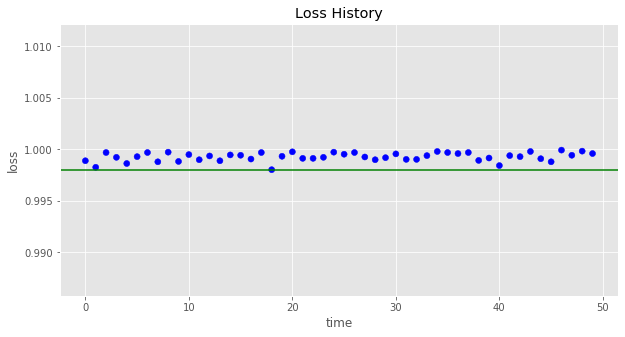

Showing Histogram of 50 jobs


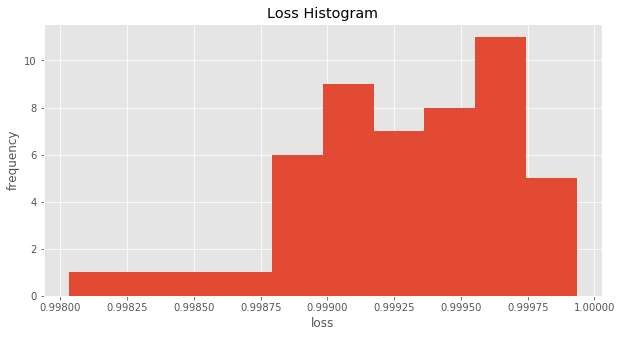

finite loss range 0.9980333333333333 0.9999333333333333 -0.001966666666666672


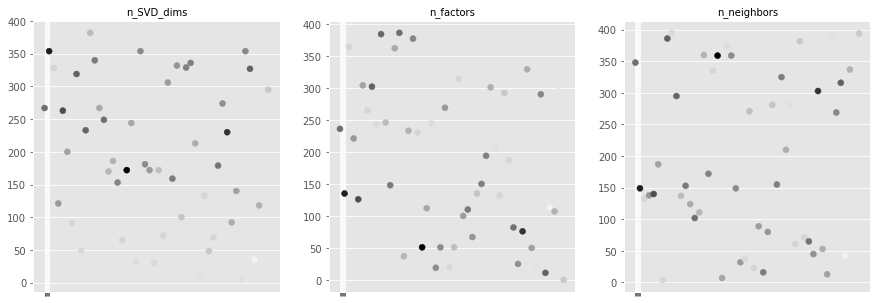

In [6]:
import hyperopt.plotting

plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_history(trials)
plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_histogram(trials)
plt.figure( figsize=(15,5))
hyperopt.plotting.main_plot_vars(trials)


## Plot performance of hyperparams across the range tested

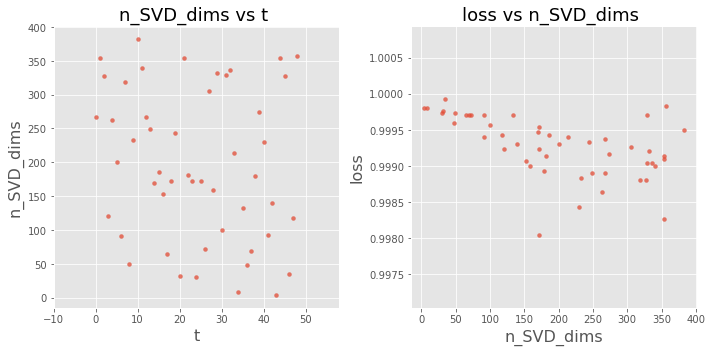

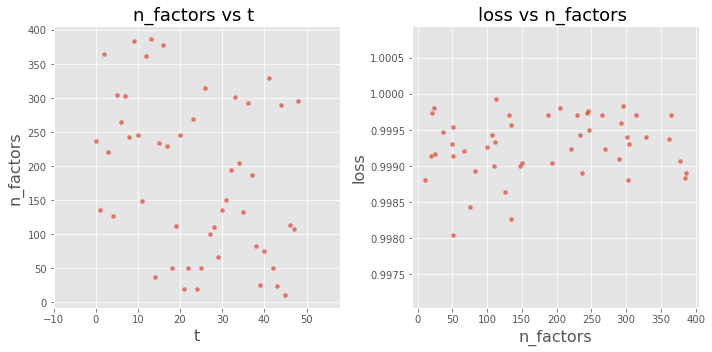

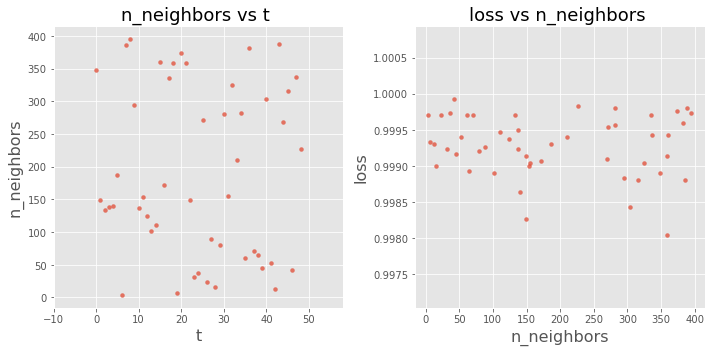

In [7]:

# only get x and y vals for plotting if there is an associated 
#  loss value. 
#  Additionally, need to deal with nested results 
def get_plot_vals(results, paramname):
    x_val = [t['tid'] for t in results]
    y_val = [t['misc']['vals'][paramname] for t in results]
    # list of lists means some entries are empty
    if type(y_val[0]) is list: 
        ytemp = np.array([y[0] if y else np.nan for y in y_val])
        y_val = np.array(ytemp)[~np.isnan(ytemp)]
        x_val = np.array(x_val)[~np.isnan(ytemp)]
    x_loss = [t['misc']['vals'][paramname] for t in results]
    y_loss = [t['result']['loss'] for t in results]
    # list of lists means some entries are empty
    if type(x_loss[0]) is list:
        xtemp = np.array([x[0] if x else np.nan for x in x_loss])
        y_loss = np.array(y_loss)[~np.isnan(xtemp)]
        x_loss = np.array(xtemp)[~np.isnan(xtemp)]
    return x_val, y_val, x_loss, y_loss

# if 'loss' not in results[-1]['result']:
#     results = results[:-1]

results = trials.trials[:-1]
# results = trials.trials
times = [t['tid'] for t in results]

for paramname in results[0]['misc']['vals'].keys():
    x_val, y_val, x_loss, y_loss = get_plot_vals(results, paramname)
    
    f, ax = plt.subplots(1,2, figsize=(10,5))
    xs = times
    # param value over time
    ax[0].set_xlim(xs[0]-10, xs[-1]+10)
    ax[0].scatter(x_val, y_val, s=20, linewidth=0.01, alpha=0.75)
    ax[0].set_title('%s vs t '%(paramname), fontsize=18)
    ax[0].set_xlabel('t', fontsize=16)
    ax[0].set_ylabel(paramname, fontsize=16)
    
    # loss vs param val
    ax[1].set_ylim(min(y_loss)-.001, max(y_loss)+.001)
    ax[1].scatter(x_loss, y_loss, s=20, linewidth=0.01, alpha=0.75)
    ax[1].set_title('loss vs %s '%(paramname), fontsize=18)
    ax[1].set_xlabel(paramname, fontsize=16)
    ax[1].set_ylabel('loss', fontsize=16)
    plt.tight_layout()


## Cross-validate model performance using the best parameters

In [8]:
from sklearn.model_selection import KFold
from recsys_utilities import get_test_Xy
# import utility functions, force reload 
import sys
sys.path.append('./')
import recsys_utilities
import importlib
importlib.reload(recsys_utilities)

def cv_score(clf, X, nfold = 5):
    """Calculate nfolds CV scores"""
    scores = []
    print('Working:',end='')
    # split data into train/test groups, nfold times
    for train_idx, test_idx in KFold(nfold,shuffle=True).split(X): 
        # fit the recommender
        clf.fit(X.iloc[train_idx,:]) 
        test_X, test_y = get_test_Xy(X.iloc[test_idx,:], 
                                     n_liked=n_liked, n_recs=n_recs )
        # evaluate score function on held-out data
        y_pred = clf.predict(test_X, num2rec=n_recs)
        scores.append(clf.score(test_y.values, y_pred))
        print('.', end='')
        
    return scores

# prep source dataframe
try: 
    df_u = df_u.set_index('userID') 
except: 
    pass

# create the recommender object
clf = Recommender_ISNNS(**defaults)
clf.set_params(**best_params)

scores = cv_score(clf, df_u, nfold = 5)

for i, score in enumerate(scores):
    print('Fold %d score = %1.4f'%(i,score))
    
print('\nMean score = %1.4f'%(np.mean(scores)))

Working:.....Fold 0 score = 0.0019
Fold 1 score = 0.0010
Fold 2 score = 0.0005
Fold 3 score = 0.0005
Fold 4 score = 0.0005

Mean score = 0.0009
